# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3044571093733877596
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12400813762134051086
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [4]:
train_dir = 'data/real_vs_fake/real-vs-fake/train'
valid_dir = 'data/real_vs_fake/real-vs-fake/valid'
test_dir =  'data/real_vs_fake/real-vs-fake/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last',
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 64
image_height = 128
image_width = 128

# Create the generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',     # Set the class mode to 'binary' since have two classes
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


fake images have label 0 and real images have label 1

In [7]:
classes = list(train_generator.class_indices.keys())
classes

['fake', 'real']

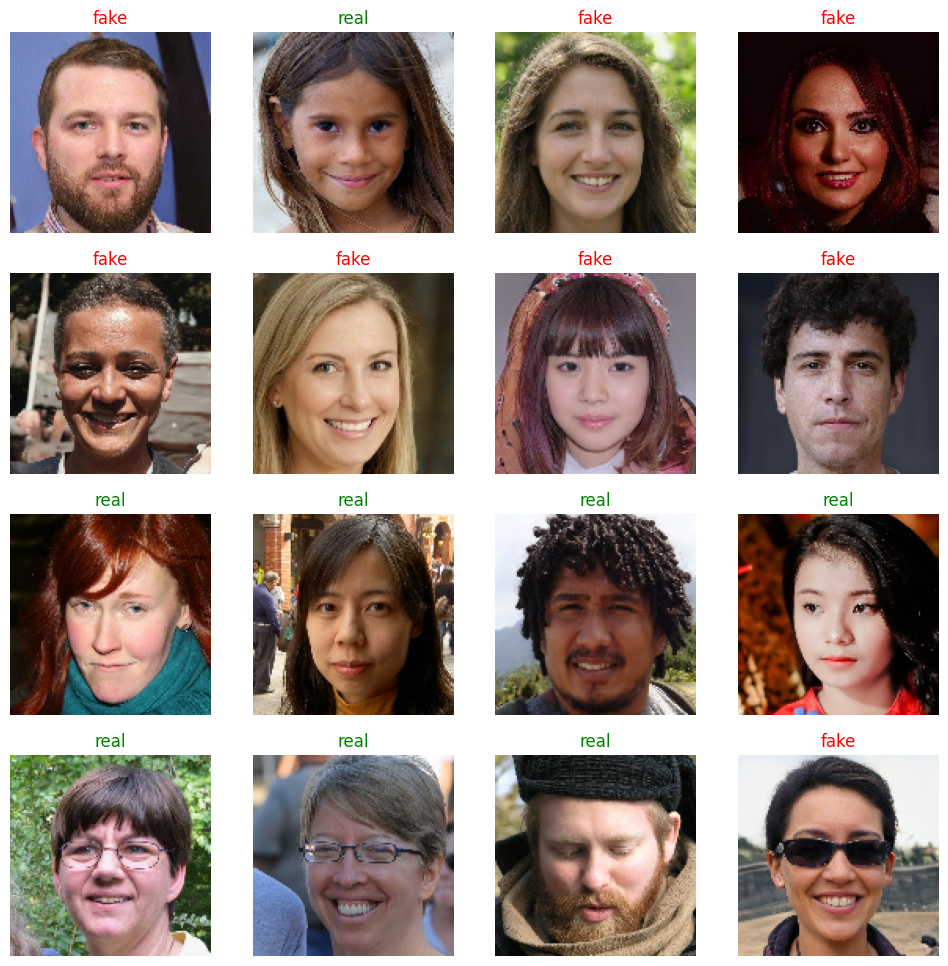

In [8]:
# Checking some images
images, labels = train_generator.next()

# Display the images along with their labels
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

    if int(labels[i]) == 0:
        title_color = 'red'
    else:
        title_color = 'green'

    ax.set_title(classes[int(labels[i])], color=title_color)

plt.show()

## Convolutional neural network

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [10]:
# Model
cnn = Sequential()

# Convolutional layers
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
cnn.add(MaxPooling2D((2, 2)))

# Flatten layer to feed into dense Dense
cnn.add(Flatten())

# Dense 
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, activation='sigmoid'))  # Adjust the number of classes

In [11]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
cnn.compile(optimizer='adam'
            ,loss='binary_crossentropy'
            ,metrics=['acc',f1_m,precision_m, recall_m])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 128)               32514176  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [13]:
cnn_history = cnn.fit(train_generator, epochs=10,validation_data=valid_generator)

Epoch 1/10
1563/1563 [==============================] - 110s 68ms/step - loss: 0.4831 - acc: 0.7809 - f1_m: 0.7764 - precision_m: 0.7837 - recall_m: 0.7842 - val_loss: 0.3682 - val_acc: 0.8341 - val_f1_m: 0.8162 - val_precision_m: 0.9056 - val_recall_m: 0.7471
Epoch 2/10
1563/1563 [==============================] - 107s 68ms/step - loss: 0.2816 - acc: 0.8822 - f1_m: 0.8809 - precision_m: 0.8777 - recall_m: 0.8891 - val_loss: 0.2645 - val_acc: 0.8883 - val_f1_m: 0.8812 - val_precision_m: 0.9286 - val_recall_m: 0.8419
Epoch 3/10
1563/1563 [==============================] - 107s 68ms/step - loss: 0.1942 - acc: 0.9210 - f1_m: 0.9204 - precision_m: 0.9162 - recall_m: 0.9276 - val_loss: 0.2218 - val_acc: 0.9134 - val_f1_m: 0.9141 - val_precision_m: 0.8903 - val_recall_m: 0.9418
Epoch 4/10
1563/1563 [==============================] - 107s 69ms/step - loss: 0.1419 - acc: 0.9444 - f1_m: 0.9438 - precision_m: 0.9403 - recall_m: 0.9495 - val_loss: 0.2279 - val_acc: 0.9118 - val_f1_m: 0.9088 - val

In [15]:
cnn_history.history

{'loss': [0.4830743372440338,
  0.2815510630607605,
  0.19417162239551544,
  0.1419171839952469,
  0.11381632089614868,
  0.08988702297210693,
  0.08089863508939743,
  0.07167947292327881,
  0.06431271135807037,
  0.059990160167217255],
 'acc': [0.7809100151062012,
  0.8821899890899658,
  0.9210299849510193,
  0.9443600177764893,
  0.9558600187301636,
  0.9658700227737427,
  0.9705700278282166,
  0.9734200239181519,
  0.976580023765564,
  0.9784700274467468],
 'f1_m': [0.7764491438865662,
  0.8809170126914978,
  0.9203625917434692,
  0.9437897801399231,
  0.9553147554397583,
  0.9654271006584167,
  0.9700157046318054,
  0.9730834364891052,
  0.9763246178627014,
  0.9781991839408875],
 'precision_m': [0.7836688160896301,
  0.8777403235435486,
  0.9162172079086304,
  0.9402611255645752,
  0.9520496129989624,
  0.9621466994285583,
  0.967720627784729,
  0.9702770113945007,
  0.9735847115516663,
  0.9763031005859375],
 'recall_m': [0.7842418551445007,
  0.8891171216964722,
  0.927609562873

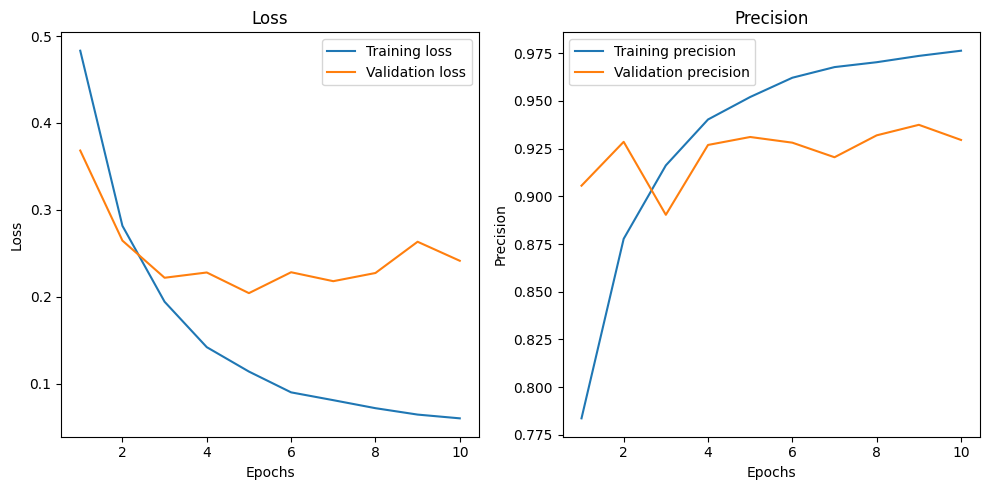

In [18]:
# Visualizing results
training_loss = cnn_history.history['loss']
validation_loss = cnn_history.history['val_loss']
training_precision = cnn_history.history['precision_m']
validation_precision = cnn_history.history['val_precision_m']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_precision, label='Training precision')
plt.plot(epochs, validation_precision, label='Validation precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Testing set
cnn.evaluate(test_generator)

313/313 [==============================] - 193s 616ms/step - loss: 0.2351 - acc: 0.9280 - f1_m: 0.9265 - precision_m: 0.9318 - recall_m: 0.9235


[0.23514609038829803,
 0.9279999732971191,
 0.9265466332435608,
 0.9318265318870544,
 0.9235023856163025]

Manual testing

1/1 [==============================] - 0s 18ms/step
REAL IMAGE


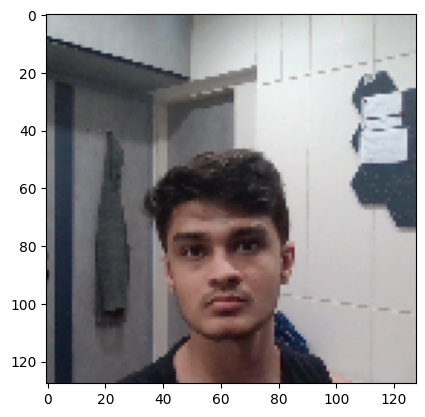

In [33]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Real image
img_path = "manual_test_images/Real.jpg"
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 128, 128, 3))
prediction = cnn.predict(img_array)
if prediction[0][0] == 1:
    print("REAL IMAGE")
else:
    print("FAKE IMAGE")


1/1 [==============================] - 0s 19ms/step
REAL IMAGE


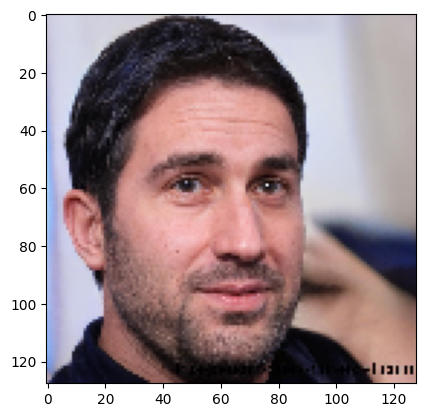

In [34]:
# Fake image(hard)
img_path = "manual_test_images/Hard.jpeg"
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 128, 128, 3))
prediction = cnn.predict(img_array)
if prediction[0][0] == 1:
    print("REAL IMAGE")
else:
    print("FAKE IMAGE")

1/1 [==============================] - 0s 18ms/step
REAL IMAGE


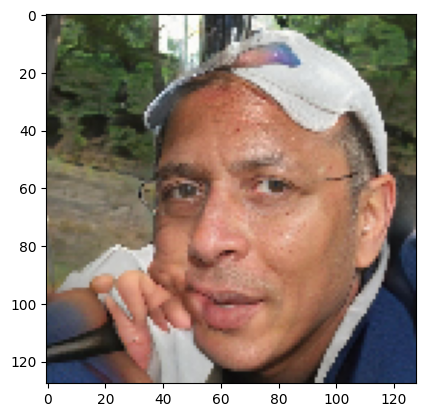

In [37]:
# Fake image(medium)
img_path = "manual_test_images/Medium.jpg"
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 128, 128, 3))
prediction = cnn.predict(img_array)
if prediction[0][0] == 1:
    print("REAL IMAGE")
else:
    print("FAKE IMAGE")

1/1 [==============================] - 0s 17ms/step
REAL IMAGE


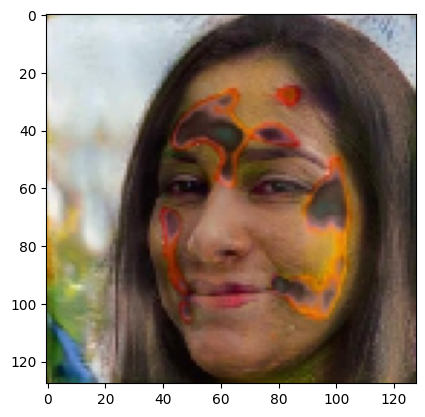

In [36]:
# Fake image(easy)
img_path = "manual_test_images/Easy.jpg"
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 128, 128, 3))
prediction = cnn.predict(img_array)
if prediction[0][0] == 1:
    print("REAL IMAGE")
else:
    print("FAKE IMAGE")

In [31]:
# Saving model
tf.keras.models.save_model(cnn, 'models/cnn_very_simple.h5')